In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

<h2>Prediction of Revenue</h2>
Features Description:

- belongs_to_collection will be turned into a Boolean variable. 1 indicates a movie is a part of collection whereas 0 indicates it is not.
- homepage will be converted into a Boolean variable that will indicate if a movie has a homepage or not.
- original_language will be replaced by a feature called is_foreign to denote if a particular film is in English or a Foreign Language.
- production_countries will be replaced with the number of countries the film was shot in.
- day will be converted into a binary feature to indicate if the film was released on a Friday.
- month will be converted into a variable that indicates if the month was a holiday season.

In [2]:
def feature_engineering(df):
    df['belongs_to_collection'] = df['belongs_to_collection'].apply(lambda x: 0 if x == np.nan else 1)
    df['homepage'] = df['homepage'].apply(lambda x: 0 if x == np.nan else 1)
    df['is_english'] = df['original_language'].apply(lambda x: 1 if x=='en' else 0)
    df = df.drop('original_language', axis=1)
    
    '''for prod_comp in prod_companies_freq.keys():
        if prod_companies_freq[prod_comp]>290:
            df['is_popular_production'] = df['production_companies'].apply(lambda x: 1 
                                                                          if prod_comp in x 
                                                                          else 0 )
            break'''
    
    for prod_comp in prod_companies_freq.keys():
        if prod_companies_freq[prod_comp]<40:
            df['is_non-popular_production'] = df['production_companies'].apply(lambda x: 1 
                                                                          if prod_comp in x 
                                                                          else 0 )
            break
    
    for genre in genres_freq.keys():
        if genres_freq[genre]>100:
            df['is_' + str(genre)] = df['genres'].apply(lambda x: 1 
                                                        if genre in x 
                                                        else 0)
            
    
    '''for director in director_freq.keys():
        if director_freq[director]>16:
            df['is_popular_director' ] = df['director'].apply(lambda x: 11 
                                                             if  x==director 
                                                             else 0)
            break'''
    
    for director in director_freq.keys():
        if director_freq[director]<4:
            df['is_non-popular_director'] = df['director'].apply(lambda x: 11 
                                                             if  x==director 
                                                             else 0)
            break
                                                    
                                                    
   
    df['production_countries'] = df['production_countries'].apply(lambda x: len(x))
    df['is_Friday'] = df['day'].apply(lambda x: 1 if x=='Fri' else 0)
    df = df.drop('day', axis=1)
    df['is_Holiday'] = df['month'].apply(lambda x: 1 if x in ['Apr', 'May', 'Jun', 'Nov'] else 0)
    df = df.drop('month', axis=1)
    df = df.drop(['title', 'cast', 'director', 'homepage'], axis=1)
    #df = df.drop(['title'], axis=1)
    #df = pd.get_dummies(df, prefix='is')
    df['runtime'] = df['runtime'].fillna(df['runtime'].mean())
    df['vote_average'] = df['vote_average'].fillna(df['vote_average'].mean())
    return df

In [3]:
#reading the pre engineered file
X_pre = pd.read_csv('X_predict_pre_engineered.csv')
y = pd.read_csv('y_predict.csv')

del X_pre['Unnamed: 0']
#create lists
X_pre['genres'] = X_pre['genres'].apply(lambda x:ast.literal_eval(x) )
X_pre['production_companies'] = X_pre['production_companies'].apply(lambda x:ast.literal_eval(x) )


#find frequency of prod companies
prod_companies_freq = defaultdict(int)
def find_freq_prod_comp(prod_comp_list):
    for item in prod_comp_list: 
            prod_companies_freq[item]+=1

#find frequency of genres
genres_freq = defaultdict(int)
def find_freq_genres(genre_list):
    for item in genre_list:
        genres_freq[item]+=1
            
#find frequency of directors           
director_freq = defaultdict(int)
def find_freq_directors(item):
    director_freq[item]+=1
            #print(item)

actor_freq = defaultdict(int)
def find_freq_actors(item):
    actor_freq[item]+=1
            #print(item)

        
X_pre['production_companies'].apply(find_freq_prod_comp)
X_pre['genres'].apply(find_freq_genres)
X_pre['director'].apply(find_freq_directors)
X_pre['cast_size']

#genres_train = X_pre['genres'].drop_duplicates()
X_pre = feature_engineering(X_pre)
X_pre = X_pre.select_dtypes(include=[np.float64, np.int64])
#X = X.reset_index()
X_pre.to_csv('X_feature_engireered.csv', index=False)

print()
#(sorted(director_freq.items(), key=lambda kv: kv[1], reverse=True) )
X_train, X_test, y_train, y_test = train_test_split(
        X_pre, y, test_size=0.1, random_state=42)

ESTIMATORS = {
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=5,
                                       random_state=0),
    "K-NN": KNeighborsRegressor(),
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor" : RandomForestRegressor(), 
    "Adaboost Regressor" :AdaBoostRegressor(),
    "Gradient Boosting Regressor":  GradientBoostingRegressor(),
}

cv_score = {}
test_score = {}
for name, estimator in ESTIMATORS.items():
    pipe = Pipeline([('Robust Scaler', RobustScaler()), (name, estimator)])
    #np.ravel(y_train,order='C')
    pipe.fit(X_train, y_train)
    cv_score[name]= sum(cross_val_score(pipe, X_train, y_train, cv=10))/10
    test_score[name] = pipe.score(X_test, y_test)
    #print(name)
    #print("Test Score"+" : "+str(estimator.score(X_test, y_test)))
    #print("Validation Score"+" : "+str(estimator.score(X_val, y_val)))  
print("Cross Validation Scores"+" : "+ str(cv_score) + "\n")


Cross Validation Scores : {'Extra Trees Regressor': 0.7290039607489605, 'K-NN': 0.6619803039234805, 'Linear Regression': 0.7302002358786033, 'Random Forest Regressor': 0.751718108844524, 'Adaboost Regressor': 0.3293403132957005, 'Gradient Boosting Regressor': 0.7758714752234807}



In [4]:
X_pre.shape

(5393, 32)

In [5]:
#sorted(director_freq.items(), key=lambda kv: kv[1], reverse=True)

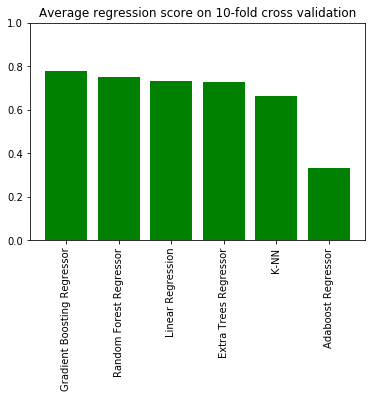

In [6]:
cv_score_list = sorted(cv_score.items(), key=lambda kv: kv[1], reverse=True)
#print("Cross Validation Scores"+" : "+ str(cv_score_list) + "\n")
x1, y1 = zip(*cv_score_list)
plt.bar(range(len(x1)),y1,  color='green' )
plt.xticks(range(len(x1)),x1, rotation='vertical')
plt.title('Average regression score on 10-fold cross validation')
plt.ylim([0,1])


print()

Test Scores : [('Random Forest Regressor', 0.7500313237293903), ('Gradient Boosting Regressor', 0.7263846727923208), ('Extra Trees Regressor', 0.723254535117571), ('K-NN', 0.7130898708241498), ('Linear Regression', 0.6896085176584776), ('Adaboost Regressor', 0.20989331818008938)]




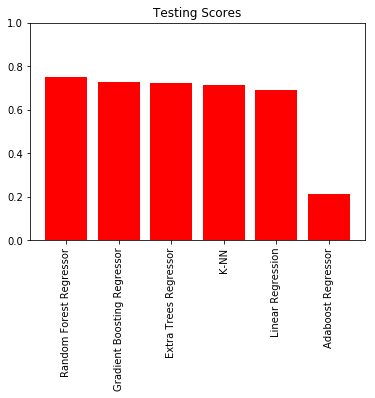

In [7]:
test_score_list = sorted(test_score.items(), key=lambda kv: kv[1], reverse=True)
print("Test Scores"+" : "+str(test_score_list) + "\n")

x1, y1 = zip(*test_score_list)
plt.bar(range(len(x1)),y1,  color='red' )
plt.xticks(range(len(x1)),x1, rotation='vertical')
plt.title('Testing Scores')
plt.ylim([0,1])
print()

In [8]:
X_pre.columns

Index(['belongs_to_collection', 'budget', 'popularity', 'production_countries',
       'runtime', 'spoken_languages', 'vote_average', 'vote_count', 'year',
       'cast_size', 'crew_size', 'is_english', 'is_non-popular_production',
       'is_Animation', 'is_Comedy', 'is_Family', 'is_Adventure', 'is_Fantasy',
       'is_Drama', 'is_Romance', 'is_Action', 'is_Crime', 'is_Thriller',
       'is_History', 'is_Science Fiction', 'is_Mystery', 'is_Horror', 'is_War',
       'is_Music', 'is_non-popular_director', 'is_Friday', 'is_Holiday'],
      dtype='object')

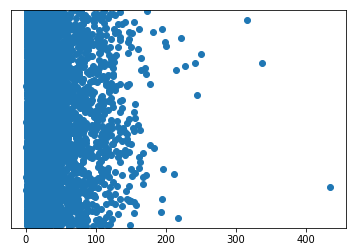

In [9]:
plt.scatter(X_pre['crew_size'], y)
plt.ylim([0,max(y)])
plt.yticks([])#np.arange(0, max(y['revenue']), step=100))
print()

<h2> CLASSIFICATION INTO REVENUE CATEGORIES </h2>

<h3>We will create classes in order to classify the movie into revenue categories and not predict an exact revenue
This might be more practical for real agencies</h3>

Main classes are:
    - revenue < 50 mil dollars
    - 50 mil < revenue < 100 mil
    - 100 mil < revenue 

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score


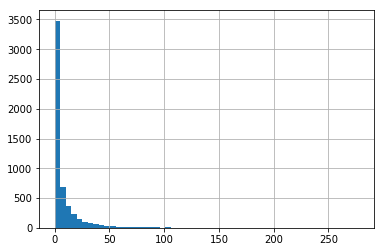

In [12]:
X = pd.read_csv('X_feature_engireered.csv')
y = pd.read_csv('y_predict.csv')
#Rescale y into millions
y['revenue'] = y['revenue'].apply(lambda x: int(x/10E6))
#y['revenue'] = y['revenue'].apply(lambda x: round(x,-1))
#plt.plot( np.linspace(0, y.size-1,y.size )-1, y, 'go')

#CREATE THE LABELS FOR THE CLASSIFICATION
y['labels'] = y['revenue'].apply(lambda x: 0 if x<25 # else 1)
                                             else (1 if x<50  # else 2))
                                                   else( 2 if x<75 else ( 3 if x <100 else 4))))
y['revenue'].hist(bins=55)
y = y.drop('revenue', axis=1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1, random_state=42)
y_train = np.ravel(y_train,order='C')

In [14]:
CLASSIFIERS = {
    "Nearest Neighbors" : KNeighborsClassifier(5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest" :  RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2),
    "Neural Net" :     MLPClassifier(alpha=1),
    "AdaBoost" : AdaBoostClassifier(), 
    "Naive Bayes" :GaussianNB(),
    #"QDA" :QuadraticDiscriminantAnalysis(),
}

    

# iterate over classifiers
for name, clf in CLASSIFIERS.items():
    clf.fit(X_train, y_train)
    print(name)
    score = clf.score(X_test, y_test)
    print("Test : "+ str(score))
    score = clf.score(X_val, y_val)
    print("validation : "+ str(score))
    score = clf.score(X_train, y_train)
    print("Train : "+ str(score))
    print("--------")

Nearest Neighbors
Test : 0.9037037037037037
validation : 0.9176954732510288
Train : 0.9329058850469429
--------
Decision Tree
Test : 0.912962962962963
validation : 0.9423868312757202
Train : 0.936340737348294
--------
Random Forest
Test : 0.8944444444444445
validation : 0.9218106995884774
Train : 0.9084039386306388
--------
Neural Net
Test : 0.8907407407407407
validation : 0.9218106995884774
Train : 0.906801007556675
--------
AdaBoost
Test : 0.9074074074074074
validation : 0.9218106995884774
Train : 0.9191664758415388
--------
Naive Bayes
Test : 0.9111111111111111
validation : 0.9362139917695473
Train : 0.916418594000458
--------


<h3> Voting classifier </h2>

In [15]:
#classifiers= [ 
clf1 = KNeighborsClassifier(5)
clf2 =  DecisionTreeClassifier(max_depth=5)
clf3 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2)
clf4 = MLPClassifier(alpha=1)
clf5 = AdaBoostClassifier()
clf6 = GaussianNB()
#]
names = ["Nearest Neighbors", 
          "Decision Tree",
         "Random Forest", 
         "Neural Net", 
         "AdaBoost",
         "Naive Bayes",
        ]
clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)
clf3 = clf3.fit(X_train, y_train)
clf4 = clf4.fit(X_train, y_train)
clf5 = clf5.fit(X_train, y_train)
clf6 = clf6.fit(X_train, y_train)
weights = [clf1.score(X_train, y_train), clf2.score(X_train, y_train), 
          clf3.score(X_train, y_train), clf4.score(X_train, y_train),
          clf5.score(X_train, y_train), clf6.score(X_train, y_train)]

eclf = VotingClassifier(estimators=
                        [("Nearest Neighbors", clf1), ("Decision Tree", clf2),
                         ("Random Forest", clf3), 
                        ("NN", clf4), ("Adaboost", clf5),
                         ("Naive Bayes", clf6)], voting='soft', weights=weights)
eclf = eclf.fit(X_train, y_train)
score = eclf.score(X_val, y_val)
print("validation : "+ str(score))
score = eclf.score(X_train, y_train)
print("Train : "+ str(score))
print("--------")

validation : 0.9259259259259259
Train : 0.9226013281428899
--------


In [16]:
'''# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold

# fix random seed for reproducibility
np.random.seed(7)
# load pima indians dataset
X = pd.read_csv('./predict/X_feature_engireered.csv')
y = pd.read_csv('./predict/y_predict.csv')
X = X.as_matrix()
y = y.as_matrix()
model = Sequential()
model.add(Dense(12, input_shape=(X.shape[1],), init='uniform', activation='sigmoid'))
model.add(Dense(1, init='uniform', activation='sigmoid'))
#model.add(Dense(12, init='uniform', activation='sigmoid'))
#model.add(Dense(1, init='uniform', activation='sigmoid'))
model.summary()

# 3
import keras
#tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)

# 4
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, batch_size=50,  verbose=1, validation_split=0.3)'''

"# Create your first MLP in Keras\nfrom keras.models import Sequential\nfrom keras.layers import Dense\nfrom keras.wrappers.scikit_learn import KerasRegressor\nfrom sklearn.model_selection import KFold\n\n# fix random seed for reproducibility\nnp.random.seed(7)\n# load pima indians dataset\nX = pd.read_csv('./predict/X_feature_engireered.csv')\ny = pd.read_csv('./predict/y_predict.csv')\nX = X.as_matrix()\ny = y.as_matrix()\nmodel = Sequential()\nmodel.add(Dense(12, input_shape=(X.shape[1],), init='uniform', activation='sigmoid'))\nmodel.add(Dense(1, init='uniform', activation='sigmoid'))\n#model.add(Dense(12, init='uniform', activation='sigmoid'))\n#model.add(Dense(1, init='uniform', activation='sigmoid'))\nmodel.summary()\n\n# 3\nimport keras\n#tbCallBack = keras.callbacks.TensorBoard(log_dir='/tmp/keras_logs', write_graph=True)\n\n# 4\nmodel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])\nmodel.fit(X, y, epochs=100, batch_size=50,  verbose=1, validation_s